# PyHMx

Demo of the alternative interface (non `f90wrap`). This is currently called `pyhmx`.

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colorbar

import camb
import pyhmx

In [2]:
def colorbar(colormap, ax, vmin=None, vmax=None):
    cmap = plt.get_cmap(colormap)

    cb_ax = matplotlib.colorbar.make_axes(ax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = matplotlib.colorbar.ColorbarBase(cb_ax[0], cmap=cmap,
                                           norm=norm, **cb_ax[1])
    
    return cb, lambda x, norm=norm: cmap(norm(x))

## Compare the HMCode implementations in HMx and in CAMB

Set cosmology and halo model parameters.

In [3]:
hmx = pyhmx.HMx()

h = 0.7
omc = 0.25
omb = 0.048
mnu = 0.12
w = -1.0
wa = 0.0
ns = 0.97
As = 2.1e-9

Theat = 10**7.8

halo_model_mode = pyhmx.constants.HMCode2016

A = 3.13
eta0 = 0.603

fields = np.array([pyhmx.constants.field_dmonly])

Run CAMB to generate the linear and non-linear matter power spectra.

In [ ]:
# Get linear power spectrum
p = camb.CAMBparams(WantTransfer=True, 
                    NonLinearModel=camb.nonlinear.Halofit(halofit_version="mead", 
                                                          HMCode_A_baryon=A, HMCode_eta_baryon=eta0))
p.set_cosmology(H0=h*100, omch2=omc*h**2, ombh2=omb*h**2, mnu=mnu)
p.set_dark_energy(w=w)
p.set_initial_power(camb.InitialPowerLaw(As=As, ns=ns))

z_lin = np.linspace(0, 3, 128, endpoint=True)
p.set_matter_power(redshifts=z_lin, kmax=20.0, nonlinear=False)

r = camb.get_results(p)
sigma8 = r.get_sigma8()[-1]
k_lin, z_lin, pofk_lin_camb = r.get_matter_power_spectrum(minkh=1e-3, maxkh=20.0, npoints=128)

omv = r.omega_de + r.get_Omega("photon") + r.get_Omega("neutrino")
omm = p.omegam

Now run HMx to get the non-linear matter power spectrum (using its HMCode implementation).

In [ ]:
cosmology = {"Omega_m"  : omm,
             "Omega_b"  : omb,
             "Omega_v"  : omv,
             "h"        : h,
             "n_s"      : ns,
             "sigma_8"  : sigma8,
             "m_nu"     : mnu}

halo_model = {"eta0" : eta0,
              "As"   : A}

Pk_HMx_dmonly = hmx.run_HMCode(cosmology=cosmology,
                               halo_model=halo_model,
                               k=k_lin,
                               z=z_lin,
                               pk_lin=pofk_lin_camb)

p.set_matter_power(redshifts=z_lin, kmax=max(k_lin), nonlinear=True)
r = camb.get_results(p)
Pk_nl_CAMB_interpolator = r.get_matter_power_interpolator()
pofk_nonlin_camb = Pk_nl_CAMB_interpolator.P(z_lin, k_lin, grid=True)

Finally, plot both the non-linear, HMCode power spectra, from CAMB and HMx.

Text(0.5, 1.0, 'HMCode vs HMx')

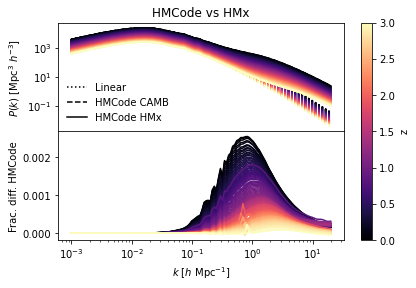

In [6]:
fig, ax = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0, right=0.95)

cb, cmap = colorbar("magma", ax, vmin=z_lin[0], vmax=z_lin[-1])
cb.set_label("z")

for i in range(len(z_lin)):
    ax[0].loglog(k_lin, pofk_lin_camb[i], ls=":", c=cmap(z_lin[i]), label="Linear" if i == 0 else None)
    ax[0].loglog(k_lin, pofk_nonlin_camb[i], ls="--", c=cmap(z_lin[i]), label="HMCode CAMB" if i == 0 else None)
    ax[0].loglog(k_lin, Pk_HMx_dmonly[i], ls="-", c=cmap(z_lin[i]), label="HMCode HMx" if i == 0 else None)

    ax[1].semilogx(k_lin, Pk_HMx_dmonly[i]/pofk_nonlin_camb[i]-1, c=cmap(z_lin[i]))

ax[0].legend(frameon=False)
ax[0].set_ylabel("$P(k)$ [Mpc$^3$ $h^{-3}$]")
ax[1].set_ylabel("Frac. diff. HMCode")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax[0].set_title("HMCode vs HMx")
# fig.savefig("plots/HMCode_test_CAMB_vs_HMx.png", dpi=300)

## Matter and pressure power spectra from HMx

HMx is much slower than HMCode, so we only use 8 redshifts here.

In [ ]:
z_lin = np.linspace(0, 2, 8, endpoint=True)
p.set_matter_power(redshifts=z_lin, kmax=20.0, nonlinear=False)

r = camb.get_results(p)

k_lin, z_lin, pofk_lin_camb = r.get_matter_power_spectrum(minkh=1e-3, maxkh=20.0, npoints=128)

In [8]:
log_Theat = np.linspace(7.6, 8.0, 3)
Pk_HMx_matter = {}

for T in log_Theat:
    print(f"Running HMx with log Theat={T:.1f}")
    halo_model={"Theat" : 10**T}
    Pk_HMx_matter[T] = hmx.run_HMx(cosmology=cosmology, halo_model=halo_model,
                                   fields=[pyhmx.constants.field_matter, pyhmx.constants.field_gas],
                                   mode=pyhmx.constants.HMx2020_matter_pressure_with_temperature_scaling,
                                   k=k_lin,
                                   z=z_lin,
                                   pk_lin=pofk_lin_camb)

Running HMx with log Theat=7.6
Running HMx with log Theat=7.8
Running HMx with log Theat=8.0


Text(0.5, 1.0, 'HMCode vs HMx')

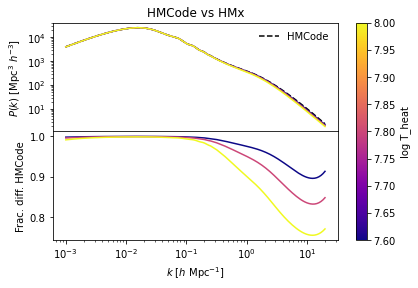

In [9]:
fig, ax = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0, right=0.95)

cb, cmap = colorbar("plasma", ax, vmin=min(log_Theat), vmax=max(log_Theat))
cb.set_label("log T_heat")

ax[0].loglog(k_lin, Pk_HMx_dmonly[0], c="k", ls="--", label="HMCode")
for T in log_Theat:
    ax[0].loglog(k_lin, Pk_HMx_matter[T][0,0,0], c=cmap(T))
    ax[1].semilogx(k_lin, Pk_HMx_matter[T][0,0,0]/Pk_HMx_dmonly[0], c=cmap(T))

ax[0].legend(frameon=False)
ax[0].set_ylabel("$P(k)$ [Mpc$^3$ $h^{-3}$]")
ax[1].set_ylabel("Frac. diff. HMCode")
ax[1].set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

ax[0].set_title("HMCode vs HMx")
# fig.savefig("plots/HMCode_vs_HMx.png", dpi=300)
